# Woodberry Classification with Deep Learning and Tensorflow #

Purpose of the classification: <br>
A classification model to predict different woodberries to be used as support to berry pickers and in the process of cleancing (quallity assure) the pickers harvest.     

Hypothesis:  
A one hot Deep Learning model based on Tensorflow can achive expected result.

Approach:
Base the evaluation on a modified model from Deeplearning.ai in the Cousera course "Neural Networks and Deep Learning".

Set-up:<br>
- Modified model from Deeplearning.ai : "Tensorflow Tutorial v3"
- Own image sets:
    - Train: A set of 1080 images of six sorts of woodberries and one set of scrap
    - Test/dev set 1: A set of 300 images including the six sorts and scrap images
    - test/dev set 2 : A second set of 300 images including the six sorts and scrap images. 


Translations from swedish woodberry sorts  i.e one hot encoding classes:
- Lingon: lingon, cowberry
- Skräp : scrap
- Berbris: berberis
- Blåbär: blueberris
- Mahonia: mahonia
- Orangebär: orangeberry (own name, not sure what sort)
- Rönnbär: rowan-berry

Note: Based on Andrew Ng's Deep Learning courses provided by Deeplearning.ai at Cousera. 

In [125]:
#Load the libarries
import time
import os
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from lingon_hdf_util import load_lingonset, load_lingonset_one  # Loads the datasets from an hdf5-file.

%matplotlib inline
np.random.seed(1)

###  Using One Hot encodings

Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:


<img src="images/onehot.png" style="width:600px;height:150px;">



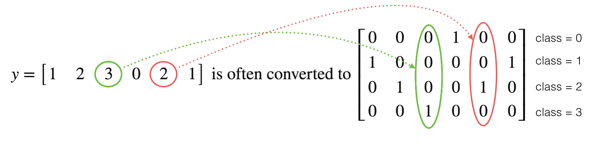

In [126]:
#Code only used do display image in GitHub
im_imvectorkiank_lingon = Image.open("images/onehot.png")
size = 600, 450
im_imvectorkiank_lingon.thumbnail(size)
display(im_imvectorkiank_lingon)

This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In tensorflow, you can use one line of code: 

- tf.one_hot(labels, depth, axis) 

**Exercise:** Implement the function below to take one vector of labels and the total number of classes $C$, and return the one hot encoding. Use `tf.one_hot()` to do this. 

In [127]:
# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')

    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)   #Djupet är lika med C efter axeln 0
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [128]:
labels = np.array([1,10,11,0,1,12,1,2,3,4,5,6])
one_hot = one_hot_matrix(labels, C = 13)
print ("one_hot = \n" + str(one_hot))
print(one_hot.shape)

one_hot = 
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(13, 12)


#  Building the network in tensorflow

This part based on of part "Buidling your first neural network with tensorflow" i.e.:
- Create the computation graph
- Run the graph



### 2.0 - Problem statement: Woodberry  Dataset


The swedish woodberry industry needs to use ordern technology to be more efficient. We have decided to explore AI as an enabler as a part of that transformation. One key use case is to be able select different type of berries and scrap, both for pickers but also on the later steps on the process. We have spent some time to gather pictures of different woodberries and based on that the follwing dataset has been created:

- **Training set**: 1080 pictures (64 by 64 pixels) of six sorts of woodberrieser and scrap, presented by numbers 0 to 6.
- **Dev/Test set 1**: 300  pictures (64 by 64 pixels) of six sorts of woodberrieser and scrap, presented by numbers 0 to 6.

Note that this is a subset of our woodberry dataset. The complete dataset contains images for many more use cases.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="images/One_hot_descr.png" style="width:900px;height:400px;"><caption><center> <u><font color='purple'> 



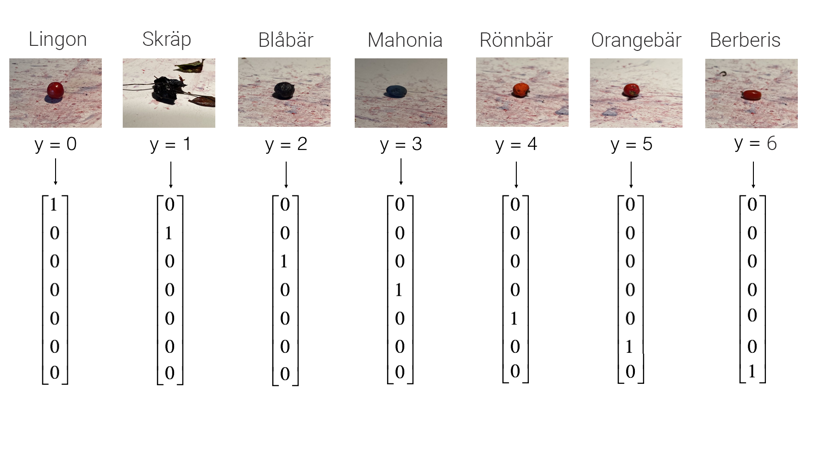

In [42]:
#Code only used do display image in GitHub
im_imvectorkiank_lingon = Image.open("images/One_hot_descr.png")
size = 900, 450
im_imvectorkiank_lingon.thumbnail(size)
display(im_imvectorkiank_lingon)

**Figure 1**</u><font color='purple'>: Woodberry dataset as one hot <br> <font color='black'> </center>
Run the following code to load the dataset.

In [41]:
#List available wooberry datasets for this use case
set_dir = "../Create_hdf5_datasets/data_sets"
search_crit1 = "one"              #One hot datasets selected
for data_set in os.listdir(set_dir):
    if search_crit1 in data_set:
        print(data_set)

Singel_lingon_scrap_berries_inhouse_dt1_m300_1024x1024x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt1_m300_128x128x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt1_m300_256x256x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt1_m300_512x512x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt1_m300_64x64x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt2_m300_1024x1024x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt2_m300_128x128x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt2_m300_256x256x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt2_m300_512x512x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_dt2_m300_64x64x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_m1080_1024x1024x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_m1080_128x128x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_m1080_256x256x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_m1080_512x512x3_T0.47one.h5
Singel_lingon_scrap_berries_inhouse_m1080_64x64x3_T0.47one.h5


### Load and verify trainingsset ###

In [129]:
#Loading the berries dataset - train
data_set_train = "Singel_lingon_scrap_berries_inhouse_m1080_64x64x3_T0.47one.h5"
X_train_orig, one_hot_labels_train, Y_train_orig, dataset_images_train, one_hot_classes, one_hot_dic = load_lingonset_one(data_set_train)

In [130]:
print(one_hot_dic)

{0: 'lingon', 1: 'skräp', 2: 'blåbär', 3: 'mahonia', 4: 'rönnbär', 5: 'orangebär', 6: 'berbris'}


Change the index below and run the cell to visualize some examples in the dataset.

0
lingon
lingon


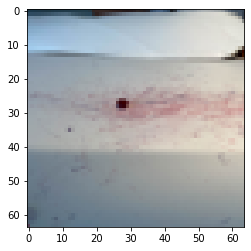

In [131]:
# Example of a picture
index = 23
print(Y_train_orig[index])
print(one_hot_labels_train[index])
print(one_hot_dic[Y_train_orig[index]])
plt.imshow(X_train_orig[index])
#print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [132]:
for index, img_class in enumerate(one_hot_labels_train):
    print(index,img_class)

0 lingon
1 lingon
2 lingon
3 lingon
4 lingon
5 lingon
6 lingon
7 lingon
8 lingon
9 lingon
10 lingon
11 lingon
12 lingon
13 lingon
14 lingon
15 lingon
16 lingon
17 lingon
18 lingon
19 lingon
20 lingon
21 lingon
22 lingon
23 lingon
24 lingon
25 lingon
26 lingon
27 lingon
28 lingon
29 lingon
30 lingon
31 lingon
32 lingon
33 lingon
34 lingon
35 lingon
36 lingon
37 lingon
38 lingon
39 lingon
40 lingon
41 lingon
42 lingon
43 lingon
44 lingon
45 lingon
46 lingon
47 lingon
48 lingon
49 lingon
50 lingon
51 lingon
52 lingon
53 lingon
54 lingon
55 lingon
56 lingon
57 lingon
58 lingon
59 lingon
60 lingon
61 lingon
62 lingon
63 lingon
64 lingon
65 lingon
66 lingon
67 lingon
68 lingon
69 lingon
70 lingon
71 lingon
72 lingon
73 lingon
74 lingon
75 lingon
76 lingon
77 lingon
78 lingon
79 lingon
80 lingon
81 lingon
82 lingon
83 lingon
84 lingon
85 lingon
86 lingon
87 lingon
88 lingon
89 lingon
90 lingon
91 lingon
92 lingon
93 lingon
94 lingon
95 lingon
96 lingon
97 lingon
98 lingon
99 lingon
100 lingon

798 skräp
799 skräp
800 skräp
801 skräp
802 skräp
803 skräp
804 skräp
805 skräp
806 skräp
807 skräp
808 skräp
809 skräp
810 skräp
811 skräp
812 skräp
813 skräp
814 skräp
815 skräp
816 skräp
817 skräp
818 skräp
819 skräp
820 skräp
821 skräp
822 skräp
823 skräp
824 skräp
825 skräp
826 skräp
827 skräp
828 skräp
829 skräp
830 skräp
831 skräp
832 skräp
833 skräp
834 skräp
835 skräp
836 skräp
837 skräp
838 skräp
839 skräp
840 skräp
841 skräp
842 skräp
843 skräp
844 skräp
845 skräp
846 skräp
847 skräp
848 skräp
849 skräp
850 skräp
851 skräp
852 skräp
853 skräp
854 skräp
855 skräp
856 skräp
857 skräp
858 skräp
859 skräp
860 skräp
861 skräp
862 skräp
863 skräp
864 skräp
865 skräp
866 skräp
867 skräp
868 skräp
869 skräp
870 skräp
871 skräp
872 skräp
873 skräp
874 skräp
875 blåbär
876 blåbär
877 blåbär
878 blåbär
879 blåbär
880 blåbär
881 blåbär
882 blåbär
883 blåbär
884 blåbär
885 blåbär
886 blåbär
887 orangebär
888 orangebär
889 orangebär
890 orangebär
891 orangebär
892 orangebär
893 orangebär


In [133]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
#X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
#X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
num_classes = len(one_hot_classes)                  # Number of classes 
Y_train = convert_to_one_hot(Y_train_orig, num_classes)
#Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
#print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
#print ("X_test shape: " + str(X_test.shape))
#print ("Y_test shape: " + str(Y_test.shape))
print(Y_train[:, 245:253])

number of training examples = 1080
X_train shape: (12288, 1080)
Y_train shape: (7, 1080)
[[1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

### Load and verify dev(test) set ###

In [134]:
#Loading the berries dataset - dev(test)
data_set_test = "Singel_lingon_scrap_berries_inhouse_dt1_m300_64x64x3_T0.47one.h5"
X_test_orig, one_hot_labels_dev_test, Y_test_orig, dataset_images_dev_test, _, _ = load_lingonset_one(data_set_test )

Change the index below and run the cell to visualize some examples in the dataset.

0
lingon
lingon


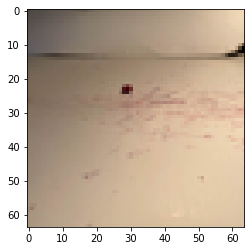

In [135]:
# Example of a picture
index = 23
print(Y_test_orig[index])
print(one_hot_labels_dev_test[index])
print(one_hot_dic[Y_test_orig[index]])
plt.imshow(X_test_orig[index])
#print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [136]:
for index, img_class in enumerate(one_hot_labels_dev_test):
    print(index,img_class)

0 lingon
1 lingon
2 lingon
3 lingon
4 lingon
5 lingon
6 lingon
7 lingon
8 lingon
9 lingon
10 lingon
11 lingon
12 lingon
13 lingon
14 lingon
15 lingon
16 lingon
17 lingon
18 lingon
19 lingon
20 lingon
21 lingon
22 lingon
23 lingon
24 lingon
25 lingon
26 lingon
27 lingon
28 lingon
29 lingon
30 lingon
31 lingon
32 lingon
33 lingon
34 lingon
35 lingon
36 lingon
37 lingon
38 lingon
39 lingon
40 lingon
41 lingon
42 lingon
43 lingon
44 lingon
45 lingon
46 lingon
47 lingon
48 lingon
49 lingon
50 lingon
51 lingon
52 lingon
53 lingon
54 lingon
55 lingon
56 lingon
57 lingon
58 lingon
59 lingon
60 lingon
61 lingon
62 lingon
63 lingon
64 lingon
65 lingon
66 lingon
67 lingon
68 lingon
69 lingon
70 lingon
71 skräp
72 skräp
73 skräp
74 skräp
75 skräp
76 skräp
77 skräp
78 skräp
79 skräp
80 skräp
81 skräp
82 skräp
83 skräp
84 skräp
85 skräp
86 skräp
87 skräp
88 skräp
89 skräp
90 skräp
91 skräp
92 skräp
93 skräp
94 blåbär
95 blåbär
96 blåbär
97 orangebär
98 orangebär
99 orangebär
100 orangebär
101 berbri

In [137]:
# Flatten the training and test images
#X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
#X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
num_classes = len(one_hot_classes)                  # Number of classes 
#Y_train = convert_to_one_hot(Y_train_orig, num_classes)
Y_test = convert_to_one_hot(Y_test_orig, num_classes)

#print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
#print ("X_train shape: " + str(X_train.shape))
#print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print(Y_test[:, 216:222])

number of test examples = 300
X_test shape: (12288, 300)
Y_test shape: (7, 300)
[[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


### Goal and approach ###

**Your goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built in numpy for cat recognition (but now using a softmax output). It is a great occasion to compare your numpy implementation to the tensorflow one. 

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 2.1 - Create placeholders

Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 

**Exercise:** Implement the function below to create the placeholders in tensorflow.

In [138]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(dtype = tf.float32, shape= (n_x, None), name = "X")
    Y = tf.placeholder(dtype = tf.float32, shape = (n_y, None), name = "Y")
    ### END CODE HERE ###
    
    return X, Y

In [139]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(6, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **X**
        </td>
        <td>
        Tensor("Placeholder_1:0", shape=(12288, ?), dtype=float32) (not necessarily Placeholder_1)
        </td>
    </tr>
    <tr> 
        <td>
            **Y**
        </td>
        <td>
        Tensor("Placeholder_2:0", shape=(6, ?), dtype=float32) (not necessarily Placeholder_2)
        </td>
    </tr>

</table>

### 2.2 - Initializing the parameters

Your second task is to initialize the parameters in tensorflow.

**Exercise:** Implement the function below to initialize the parameters in tensorflow. You are going use Xavier Initialization for weights and Zero Initialization for biases. The shapes are given below. As an example, to help you, for W1 and b1 you could use: 

```python
W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
```
Please use `seed = 1` to make sure your results match ours.

In [140]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [7, 12]      #Ändrat påga fel tror att det ska mappa antalet y
                        b3 : [7, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [7,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1)) #Mofified to fit dataset
    b3 = tf.get_variable("b3", [7,1], initializer = tf.zeros_initializer()) #Modified to fit dataset
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [141]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **W1**
        </td>
        <td>
         < tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b1**
        </td>
        <td>
        < tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **W2**
        </td>
        <td>
        < tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b2**
        </td>
        <td>
        < tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref >
        </td>
    </tr>

</table>

As expected, the parameters haven't been evaluated yet.

### 2.3 - Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [142]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                         # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                     # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                        # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                     # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                        # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [143]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(7, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **Z3**
        </td>
        <td>
        Tensor("Add_2:0", shape=(6, ?), dtype=float32)
        </td>
    </tr>

</table>

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

### 2.4 Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Question**: Implement the cost function below. 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [144]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [145]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **cost**
        </td>
        <td>
        Tensor("Mean:0", shape=(), dtype=float32)
        </td>
    </tr>

</table>

### 2.5 - Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

### 2.6 - Building the model

Now, you will bring it all together! 

**Exercise:** Implement the model. You will be calling the functions you had previously implemented.

In [146]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Run the following cell to train your model! On our machine it takes about 5 minutes. Your "Cost after epoch 100" should be 1.016458. If it's not, don't waste time; interrupt the training by clicking on the square (⬛) in the upper bar of the notebook, and try to correct your code. If it is the correct cost, take a break and come back in 5 minutes!

Cost after epoch 0: 1.894148
Cost after epoch 100: 0.553262
Cost after epoch 200: 0.344738
Cost after epoch 300: 0.201102
Cost after epoch 400: 0.204028
Cost after epoch 500: 0.126115
Cost after epoch 600: 0.098670
Cost after epoch 700: 0.091899
Cost after epoch 800: 0.081865
Cost after epoch 900: 0.067146
Cost after epoch 1000: 0.070985
Cost after epoch 1100: 0.044779
Cost after epoch 1200: 0.044426
Cost after epoch 1300: 0.088550
Cost after epoch 1400: 0.034134


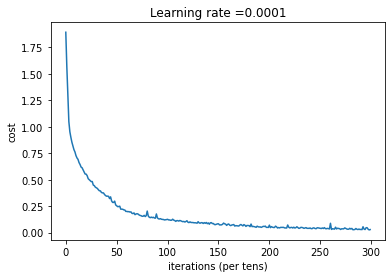

Parameters have been trained!
Train Accuracy: 0.9907407
Test Accuracy: 0.48


In [147]:
parameters = model(X_train, Y_train, X_test, Y_test)

**Expected Output**:

<table> 
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.999074
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.716667
        </td>
    </tr>

</table>

Amazing, your algorithm can recognize a sign representing a figure between 0 and 5 with 71.7% accuracy.

**Insights**:
- Your model seems big enough to fit the training set well. However, given the difference between train and test accuracy, you could try to add L2 or dropout regularization to reduce overfitting. 
- Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

### 2.7 - Test with your own image (optional / ungraded exercise)

Congratulations on finishing this assignment. You can now take a picture of your hand and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right!

(12288, 1)
Algorithm predicts: y = 0, lingon


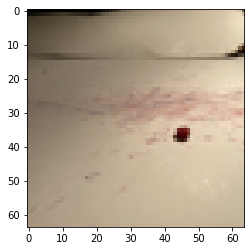

In [124]:
## START CODE HERE ##
#my_image = "berberis1.JPEG"
#my_image = "blåbär1.jpg"
#my_image = "lingon1.JPEG"
my_image = "lingon2.JPEG"
#my_image = "orangebär1.JPEG" 
#my_image = "rönnbär1.JPEG"
#my_image = "skräp1.JPEG"
#my_image = "skräp2.JPEG"
#my_image = "mahonia.JPEG"

num_px = 64
num_py = 64
## END CODE HERE ##

fname = "images/" + my_image
image_conv = Image.open(fname)
image_conv = image_conv.resize((num_px,num_px))
image = np.asarray(image_conv)
image = image/255.
my_image = image.reshape(1, num_px*num_px*3).T
#print(my_image.shape)


my_image_prediction = predict(my_image, parameters)
print(my_image.shape)
class_index = int(np.squeeze(my_image_prediction))
print("Algorithm predicts: y = " + str(np.squeeze(my_image_prediction))+", "+one_hot_dic[class_index])
plt.imshow(image)


You indeed deserved a "thumbs-up" although as you can see the algorithm seems to classify it incorrectly. The reason is that the training set doesn't contain any "thumbs-up", so the model doesn't know how to deal with it! We call that a "mismatched data distribution" and it is one of the various of the next course on "Structuring Machine Learning Projects".

### 2.8 - Test a test set

The follwoing test is with a second test/deve set i.e. same distribution as the previous one.

In [46]:
#Load second test set
#Loading the berries dataset - test
data_set_test = "Singel_lingon_scrap_berries_inhouse_dt2_m300_64x64x3_T0.47one.h5"
X_test_orig_dt2, one_hot_labels_dt2, Y_test_orig_dt2, dataset_images_dt2, _, _ = load_lingonset_one(data_set_test )

0
lingon
lingon


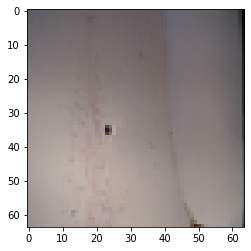

In [121]:
# Example of a picture from the dataset
index = 197
print(Y_test_orig_dt2[index])
print(one_hot_labels_dt2[index])
print(one_hot_dic[Y_test_orig[index]])
plt.imshow(X_test_orig_dt2[index])
#print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [50]:
for index, img_class in enumerate(one_hot_labels_dt2):
    print(index,img_class)

0 lingon
1 lingon
2 lingon
3 lingon
4 lingon
5 lingon
6 lingon
7 lingon
8 lingon
9 lingon
10 lingon
11 lingon
12 lingon
13 lingon
14 lingon
15 lingon
16 lingon
17 lingon
18 lingon
19 lingon
20 lingon
21 lingon
22 lingon
23 lingon
24 lingon
25 lingon
26 lingon
27 lingon
28 lingon
29 lingon
30 lingon
31 lingon
32 lingon
33 lingon
34 lingon
35 lingon
36 lingon
37 lingon
38 lingon
39 lingon
40 lingon
41 lingon
42 lingon
43 lingon
44 lingon
45 lingon
46 lingon
47 lingon
48 lingon
49 lingon
50 lingon
51 lingon
52 lingon
53 lingon
54 lingon
55 lingon
56 lingon
57 lingon
58 lingon
59 lingon
60 lingon
61 lingon
62 lingon
63 lingon
64 lingon
65 lingon
66 lingon
67 lingon
68 lingon
69 lingon
70 lingon
71 skräp
72 skräp
73 skräp
74 skräp
75 skräp
76 skräp
77 skräp
78 skräp
79 skräp
80 skräp
81 skräp
82 skräp
83 skräp
84 skräp
85 skräp
86 skräp
87 skräp
88 skräp
89 skräp
90 skräp
91 skräp
92 blåbär
93 skräp
94 berbris
95 berbris
96 skräp
97 rönnbär
98 rönnbär
99 rönnbär
100 rönnbär
101 rönnbär
102 

In [150]:
# Flatten the training and test images
X_test_flatten_dt2 = X_test_orig_dt2.reshape(X_test_orig_dt2.shape[0], -1).T

# Normalize image vectors
X_test_dt2 = X_test_flatten_dt2/255.

# Convert training and test labels to one hot matrices
num_classes = len(one_hot_classes)                  # Number of classes 

#Y_train = convert_to_one_hot(Y_train_orig, num_classes)
Y_test_dt2 = convert_to_one_hot(Y_test_orig_dt2, num_classes)

print ("number of test examples = " + str(X_test_dt2.shape[1]))
print ("X_test_dt2 shape: " + str(X_test_dt2.shape))
print ("Y_test_dt2 shape: " + str(Y_test_dt2.shape))
print(Y_test_dt2[:, 90:101])

number of test examples = 300
X_test_dt2 shape: (12288, 300)
Y_test_dt2 shape: (7, 300)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]]


In [152]:
# Run prediction for dt2
Y_pred = []
for image_index in range (300): 
    image_pred = X_test_dt2[:,image_index]
    image_pred = image_pred.reshape(1, num_px*num_px*3).T
    image_prediction = predict(image_pred, parameters)
    Y_pred.append(image_prediction)

"""
for image_index in range(X_test.shape[1]):
    image_pred = X_test[:,image_index]
    image_pred = image_pred.reshape(1, num_px*num_px*3).T
    image_prediction = predict(image_pred, parameters)
    print(image_prediction)
    Y_pred.append(image_prediction)
"""
print(np.squeeze(Y_pred))
    



[1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3
 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


In [153]:
print(Y_test_orig_dt2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 6 6 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 2 2 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 6 6 6 1 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 2 2 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


In [165]:

corrects = 0
for index in range(Y_test_orig_dt2.shape[0]):
    if Y_test_orig_dt2[index] == np.squeeze(Y_pred[index]):
                   corrects += 1

print("Test accuracy dt2: {:.2f}".format(corrects/len(Y_test_orig_dt2)))
                

Test accuracy dt2: 0.33


<font color='blue'>
**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.